<a href="https://colab.research.google.com/github/cedro3/others2/blob/main/GLID_3_Inferencing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

  0%|          | 0/25 [00:00<?, ?it/s]

Images stored in output/


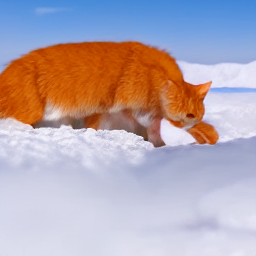

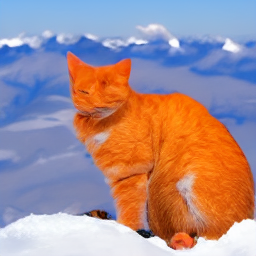

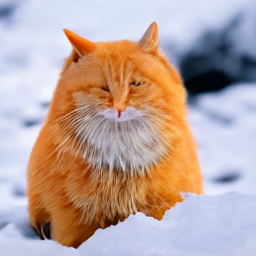

In [ ]:
#@markdown # **GLID-3** inferencing
#@markdown #### simplified by mega b#6696
#@markdown <a href="https://discord.gg/xBPBXfcFHd"><img alt="Join us on Discord" src="https://img.shields.io/discord/823813159592001537?color=5865F2&logo=discord&logoColor=white"></a></br>
#@markdown ---
import os, sys
from IPython.display import clear_output, Image, display
import glob

if not os.path.isdir('/content/glid-3'):
  !nvidia-smi -L
  !git clone https://github.com/Jack000/glid-3
  %cd glid-3/
  !pip install -q -e .
  !pip install -q git+https://github.com/openai/CLIP.git
  !git clone https://github.com/CompVis/latent-diffusion.git
  !pip install -q -e latent-diffusion/.
  sys.path.insert(1, '/content/glid-3/latent-diffusion')
  !pip install -q dalle-pytorch
  !mkdir output
  clear_output()
  print("Restarting runtime, re-run this cell.")
  !pip install -q pyyaml>=5.1 transformers typing_extensions 
  os.kill(os.getpid(), 9)

if not os.path.isfile('/content/glid-3/vq-f8/model.ckpt'):
  %cd glid-3/
  !wget https://ommer-lab.com/files/latent-diffusion/vq-f8.zip && unzip vq-f8.zip -d vq-f8
  # download latest pretrained glid-3 model
  !wget https://dall-3.com/models/glid-3/ema-latest.pt
  import io
  import math
  import sys
  import requests
  import torch
  from torch import nn
  from torch.nn import functional as F
  from torchvision import transforms
  from torchvision.transforms import functional as TF
  from tqdm.notebook import tqdm
  import numpy as np
  from guided_diffusion.script_util import create_model_and_diffusion, model_and_diffusion_defaults
  from einops import rearrange
  from math import log2, sqrt
  import argparse
  import pickle
  from clip_custom import clip
  from omegaconf import OmegaConf
  from ldm.util import instantiate_from_config
  import os

  def fetch(url_or_path):
      if str(url_or_path).startswith('http://') or str(url_or_path).startswith('https://'):
          r = requests.get(url_or_path)
          r.raise_for_status()
          fd = io.BytesIO()
          fd.write(r.content)
          fd.seek(0)
          return fd
      return open(url_or_path, 'rb')

  device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
  print('Using device:', device)

  model_params = {
      'attention_resolutions': '32,16,8',
      'class_cond': False,
      'diffusion_steps': 1000,
      'rescale_timesteps': True,
      'timestep_respacing': '27',  # Modify this value to decrease the number of
                                    # timesteps.
      'image_size': 32,
      'learn_sigma': True,
      'noise_schedule': 'cosine',
      'num_channels': 320,
      'num_head_channels': 64,
      'num_res_blocks': 3,
      'encoder_channels': 768,
      'resblock_updown': True,
      'use_fp16': True,
      'use_scale_shift_norm': True
  }


  model_config = model_and_diffusion_defaults()
  model_config.update(model_params)


  # Load models
  model, diffusion = create_model_and_diffusion(**model_config)
  model.load_state_dict(torch.load("ema-latest.pt", map_location='cpu'))
  model.requires_grad_(False).eval().to(device)

  if model_config['use_fp16']:
      model.convert_to_fp16()
  else:
      model.convert_to_fp32()

  def set_requires_grad(model, value):
      for param in model.parameters():
          param.requires_grad = value

  # LDM
  config = OmegaConf.load("./vq-f8/config.yaml")
  pl_sd = torch.load("./vq-f8/model.ckpt", map_location="cpu")
  sd = pl_sd["state_dict"]
  ldm = instantiate_from_config(config.model)
  ldm.load_state_dict(sd, strict=False)
  ldm.to(device)
  ldm.eval()
  set_requires_grad(ldm, False)

  # clip
  clip_model, clip_preprocess = clip.load('ViT-L/14', device=device, jit=False)
  clip_model.eval().requires_grad_(False)
  set_requires_grad(clip_model, False)

  clear_output()

  



!rm -f output/*.png

prompt = "an orange cat is hugging a rock covered with snow at the top of the world's tallest mountain." #@param {type: "string"}

guidance_scale = 5.0 #@param {type:"number"}
width = 256 #@param {type:"number"}
height =  256#@param {type:"number"}
batch_size = 3 #@param {type:"number"}
num_batches = 1 #@param {type:"number"}
negative = "" #@param {type: "string"}

"""!python sample.py \
  --model_path ema-latest.pt \
  --ldm_path vq-f8/model.ckpt \
  --ldm_config_path vq-f8/config.yaml \
  --width "$width" \
  --height "$height" \
  --batch_size "$batch_size" \
  --num_batches "$num_batches" \
  --guidance_scale "$guidance_scale" \
  --text "$prompt" \
  --clip_score"""
    
def do_run():

    text = clip.tokenize([prompt]*batch_size, truncate=True).to(device)

    text_emb, text_out = clip_model.encode_text(text, out=True)
    text_emb_norm = text_emb[0] / text_emb[0].norm(dim=-1, keepdim=True)

    text_out = text_out.permute(0, 2, 1)

    text_blank = clip.tokenize([negative]*batch_size).to(device)

    text_emb_blank, text_out_blank = clip_model.encode_text(text_blank, out=True)
    text_out_blank = text_out_blank.permute(0, 2, 1)

    kwargs = { "xf_proj": torch.cat([text_emb, text_emb_blank], dim=0), "xf_out": torch.cat([text_out, text_out_blank], dim=0) }

    # Create a classifier-free guidance sampling function
    def model_fn(x_t, ts, **kwargs):
        half = x_t[: len(x_t) // 2]
        combined = torch.cat([half, half], dim=0)
        model_out = model(combined, ts, **kwargs)
        eps, rest = model_out[:, :3], model_out[:, 3:]
        cond_eps, uncond_eps = torch.split(eps, len(eps) // 2, dim=0)
        half_eps = uncond_eps + guidance_scale * (cond_eps - uncond_eps)
        eps = torch.cat([half_eps, half_eps], dim=0)
        return torch.cat([eps, rest], dim=1)

    sample_fn = diffusion.plms_sample_loop_progressive

    def save_sample(i, sample, clip_score=False):
        for k, image in enumerate(sample['pred_xstart'][:batch_size]):
            image = 2*image
            im = image.unsqueeze(0)
            im_quant, _, _ = ldm.quantize(im)
            out = ldm.decode(im_quant)

            out = TF.to_pil_image(out.squeeze(0).add(1).div(2).clamp(0, 1))

            filename = f'output/_progress_{i * batch_size + k:05}.png'
            out.save(filename)

            if clip_score:
                image_emb = clip_model.encode_image(clip_preprocess(out).unsqueeze(0).to(device))
                image_emb_norm = image_emb / image_emb.norm(dim=-1, keepdim=True)

                similarity = torch.nn.functional.cosine_similarity(image_emb_norm, text_emb_norm, dim=-1)

                final_filename = f'output/_{similarity.item():0.3f}_{i * batch_size + k:05}.png'
                os.rename(filename, final_filename)

    for i in range(num_batches):
        samples = sample_fn(
            model_fn,
            (batch_size*2, 4, int(height/8), int(width/8)),
            clip_denoised=False,
            model_kwargs=kwargs,
            cond_fn=None,
            device=device,
            progress=True,
        )

        for j, sample in enumerate(samples):
            if j > 0 and j % 50 == 0:
                save_sample(i, sample)
        save_sample(i, sample)


do_run()

print("Images stored in output/")

for img_path in glob.glob('output/*.png'):
    display(Image(filename=img_path))